In [73]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
feature_type = "network" # "plant" / "network"
networks_type = "weighted" # "binary" / "weighted" / "binarized_weighted"

pollinatos_taxonomic_level_across_networks_path = "../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
features_path = f"../data/features/{feature_type}_features/{networks_type}/features_with_classification.csv"
network_features = ["connectance", "extinction.slope.LL", "robustness.LL", "robustness_mean", "delta_transformed_ vulnerability.LL",
                    "delta_transformed_ Shannon diversity", "delta_transformed_ togetherness.LL"]
plant_features = ["d", "delta_transformed_ d", "nestedness_contribution", "delta_transformed_ proportional.generality", "interaction.push.pull"]

In [83]:
pollinators_taxonomic_level_across_networks = pd.read_csv(pollinatos_taxonomic_level_across_networks_path)
pollinators_taxonomic_level_across_networks.network_id = pollinators_taxonomic_level_across_networks.network_id.astype(np.int16)   
pollinators_taxonomic_level_across_networks = pollinators_taxonomic_level_across_networks.query(f"network_type == '{networks_type if not 'weighted' in networks_type else 'weighted'}'")
print(f"# networks with taxonomic classification data = {pollinators_taxonomic_level_across_networks.shape[0]:,}")
pollinators_taxonomic_level_across_networks.notna().sum() / pollinators_taxonomic_level_across_networks.shape[0]

# networks with taxonomic classification data = 595


network_type          1.000000
network_id            1.000000
taxon_rank            1.000000
num_ranks             1.000000
highest_taxon_rank    0.988235
dtype: float64

In [84]:
features = pd.read_csv(features_path)
features["network_id"] = features.network.apply(lambda x: int(x.replace(".csv", "")))
features = features.merge(pollinators_taxonomic_level_across_networks[["network_id", "num_ranks", "highest_taxon_rank"]], on="network_id", how="left")
features = features.rename(columns={"num_ranks": "num_pollinator_taxonomic_ranks", "highest_taxon_rank": "highest_pollinator_rank"}).drop(["network_id"] + [c for c in features.columns if "Unnamed" in c or c.endswith(".1")], axis=1)
features = features.loc[:,~features.columns.duplicated()].copy()
features.to_csv(features_path, index=False)
features.notna().sum() / features.shape[0]

connectance                          1.000000
web asymmetry                        1.000000
links per species                    1.000000
number of compartments               1.000000
compartment diversity                0.074266
                                       ...   
delta_transformed_ robustness_max    0.000000
is_polyploid_poly_frac               0.870466
is_polyploid_missing_frac            0.993092
num_pollinator_taxonomic_ranks       0.993092
highest_pollinator_rank              0.989637
Length: 106, dtype: float64

In [89]:
if feature_type == "plant":
    df_to_plot = features.groupby(["original_name", "highest_pollinator_rank"]).mean()
else:
    df_to_plot = features.groupby(["network", "highest_pollinator_rank"]).mean()
    df_to_plot["is_polyploid_frac_more_than_half"] = df_to_plot.is_polyploid_poly_frac > 0.5

In [95]:
[c for c in df_to_plot.columns if "Shannon" in c]

['Shannon diversity', 'delta_transformed_ Shannon diversity']

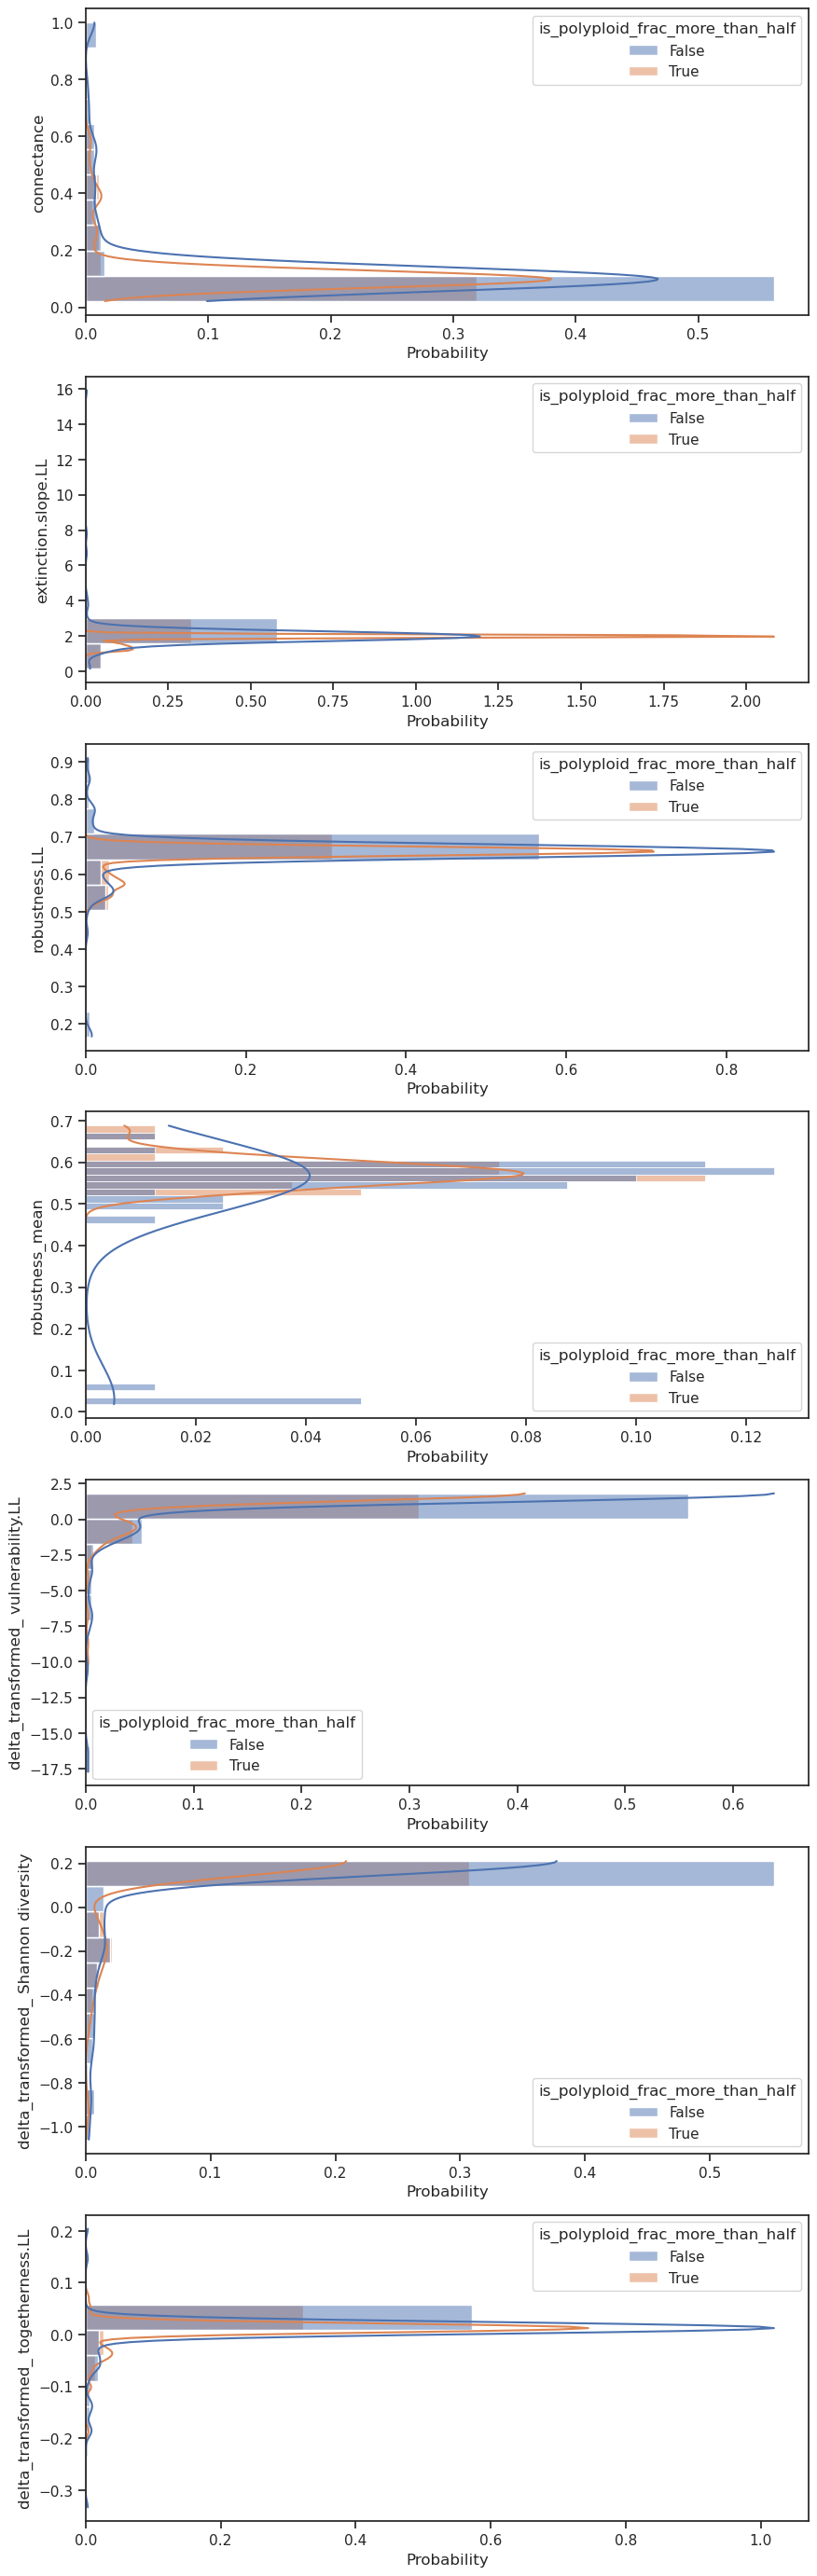

In [97]:
features_to_plot = network_features if feature_type == "network" else plant_features
color_by = "is_polyploid" if feature_type == "plant" else "is_polyploid_frac_more_than_half"
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, figsize=(10, 5*len(features_to_plot)))
for feature in features_to_plot:
    sns.histplot(data=df_to_plot, y=feature, hue=color_by, stat="probability", kde=True, ax=axes[features_to_plot.index(feature)])